#tensorflow=2.6 cuda=11.2 RTX4060

In [1]:
import pandas as pd
import re
import os
import jieba
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, SpatialDropout1D, Bidirectional, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
file_path ="D:\\big_data_R\\ptt-stock20240604.csv"
df = pd.read_csv(file_path)
df.head()

,Unnamed: 0,title,title_id,time,content,push_id,push_content,push_time
0,0,[新聞] 魏哲家霸氣喊「台積電無敵手」 擴廠連,keel90135 (尼可),Tue Jun 4 15:55:30 2024,原文標題：魏哲家霸氣喊「台積電無敵手」 擴廠連說3次台灣原文連結：https://finan...,xiaoyao,已知利多 我阿嬤都知道,06/04 15:57
1,1,[新聞] 魏哲家霸氣喊「台積電無敵手」 擴廠連,keel90135 (尼可),Tue Jun 4 15:55:30 2024,原文標題：魏哲家霸氣喊「台積電無敵手」 擴廠連說3次台灣原文連結：https://finan...,strlen,尼這樣 美國老大哥又不高興惹,06/04 15:58
2,2,[新聞] 魏哲家霸氣喊「台積電無敵手」 擴廠連,keel90135 (尼可),Tue Jun 4 15:55:30 2024,原文標題：魏哲家霸氣喊「台積電無敵手」 擴廠連說3次台灣原文連結：https://finan...,chinaeatshit,不說台灣明天就跌停了 說台灣又是預料中 簡單的說,06/04 15:58
3,3,[新聞] 魏哲家霸氣喊「台積電無敵手」 擴廠連,keel90135 (尼可),Tue Jun 4 15:55:30 2024,原文標題：魏哲家霸氣喊「台積電無敵手」 擴廠連說3次台灣原文連結：https://finan...,chinaeatshit,就是沒有利多,06/04 15:58
4,4,[新聞] 魏哲家霸氣喊「台積電無敵手」 擴廠連,keel90135 (尼可),Tue Jun 4 15:55:30 2024,原文標題：魏哲家霸氣喊「台積電無敵手」 擴廠連說3次台灣原文連結：https://finan...,ccdrv,已反應 全世界都知道,06/04 15:58


In [3]:
def remove_number(text):
    return re.sub(r'[0-9.]', '', text)
df['push_content']=df['push_content'].apply(remove_number)

In [4]:
#remove url
webs=[]
for i in df['push_content']:
    website=re.findall(r"http[s]?://[^\s]+",i)
    if len(website)>0:
        webs.append(website)
        
for j in webs:
    df['push_content']=df['push_content'].replace(j,"")
    

In [5]:
df=df.dropna(axis=0,how='any',thresh=None,subset=None,inplace=False)
print(df.isnull().sum())

Unnamed: 0      0
title           0
title_id        0
time            0
content         0
push_id         0
push_content    0
push_time       0
dtype: int64


In [6]:
positive_words = ['賺爛','利多','月增','年增','穩穩','穩','厲害','推','降息','轉虧為盈','減少成本','成本減少','跳空','多賺','發大財','有前景',
                  '盈利','利好','強勁','繁榮','讚','無敵','霸氣','噴','加碼','猛','順差','買超','牛市','潛力股','創新高','GG','台積','贏','發了',
                  '強勢','熱點','大漲','增量','看漲','超額收益','穩賺','高成長','推','降息','漲','ai','amd','nvidia','AI',"AMD",'NVIDIA']

middle_words = ['投資','收益','獲利','份額','營收','市場','業績','需求','進步','效率','生產','財務','股息','銷售','業績','預期',
                '回報','風險','收益率','成長','回報','利潤','市值','經濟','消息','預期','利']

positive_degree=['增加','提升','更多','上升','飆升','提高','改善','強勁','增長','擴展','看好','好','超額','無限']

negative_degree=['減少','下降','放緩','面臨','低迷','不明','停滯','不佳','衰退','下滑','跌','壞','低','不如','沒有']

negative_words = ['韭菜','缺電','升息','出貨','跌停','gg','月減','年減','破產','高失業','高通貨膨脹','雷','崩潰','崩盤','利多出盡','空頭',
                  '跌破','中國','跌到','拉回','停損','賺不到','不會賺','跌爛','大跌','散戶','崩','暴跌','跌幅','套','殺','悲','穩死',
                  '跳水','賣超','倒','哭','完蛋','回檔','衰','賠','虧損','下挫','貶值','裁員','魯蛇','破產','重組','減產','爛死', 
                  '經濟衰退','債務','虧本','虧空','失敗','損失','赤字','退市','笑死','違約','緊縮','利空','qq','慘','折損','沒賺到','賣',
                  '萎縮','撤資','震盪','惡化','失敗','困難','賣壓','下去','xd','制裁','沒有利多','怕','QQ','別買','XD','臭','隱憂','小心']

In [7]:
def classify_sentence(sentence):
    # 尋找負面形容詞和中立詞語同時出現
    if any(neg_word in sentence for neg_word in negative_degree):
        if any(mid_word in sentence for mid_word in middle_words):
            return 'negative'
    
    # 尋找負面詞語
    if any(word in sentence for word in negative_words):
        return 'negative'
    
    # 尋找正面詞語
    if any(word in sentence for word in positive_words):
        return 'positive'
    
    # 尋找正面形容詞和中立詞語同時出現
    if any(pos_word in sentence for pos_word in positive_degree):
        if any(mid_word in sentence for mid_word in middle_words):
            return 'positive'
    
    
    return None  # If no match

In [8]:
# 應用情感標籤函數並生成sentiment列
df['sentiment'] = df['push_content'].apply(classify_sentence)
# 只保留正向和負向的標籤
df = df[df['sentiment'].notnull()]
print('回文數目（全部）：%d' % df.shape[0])
print('回文數目（正面）：%d' % df[df.sentiment=='positive'].shape[0])
print('回文數目（負面）：%d' % df[df.sentiment=='negative'].shape[0])

回文數目（全部）：4124
回文數目（正面）：1955
回文數目（負面）：2169


In [9]:
stop_words=[]
with open("C:\\Users\\user\\Downloads\\cn_stopwords_1.txt", 'r', encoding='utf8') as f:
    stop_words = f.read().split('\n') 
stop_words.append('\n')
def remove_stopwords(text):
    words = jieba.lcut(text)
    return ' '.join([word for word in words if word not in stop_words])
df['content_cut']=df['push_content'].apply(remove_stopwords)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\user\AppData\Local\Temp\jieba.cache
Loading model cost 1.282 seconds.
Prefix dict has been built successfully.


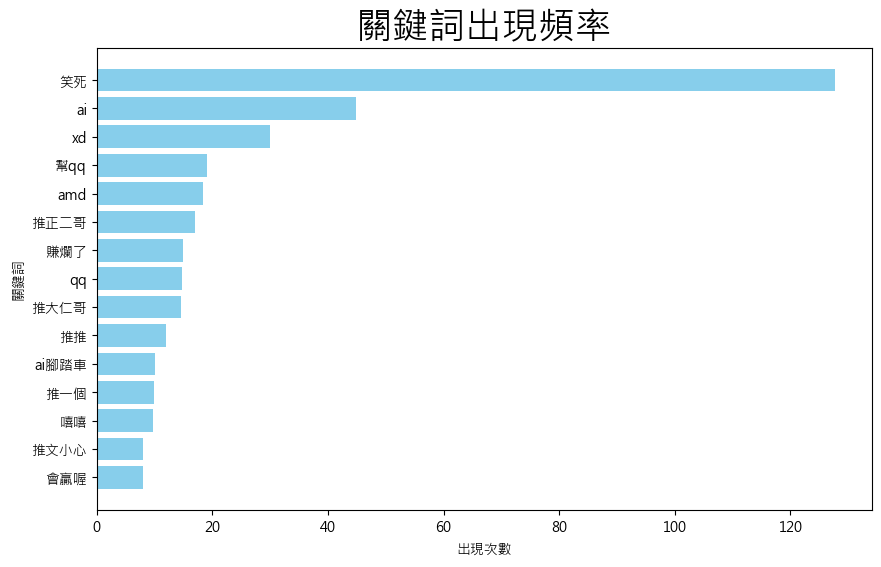

In [10]:
vectorizer = TfidfVectorizer(max_features=50)

X = vectorizer.fit_transform(df.push_content)

# 獲取關鍵詞列表
keywords = vectorizer.get_feature_names_out()

# 計算每個關鍵詞的總出現次數
word_count = np.sum(X.toarray(), axis=0)

# 創建關鍵詞和出現次數的數據框
keyword_df = pd.DataFrame({'keyword': keywords, 'count': word_count})

# 根據出現次數進行排序
keyword_df = keyword_df.sort_values(by='count', ascending=False)
# 繪製關鍵詞頻率圖
plt.figure(figsize=(10, 6))
plt.barh(keyword_df['keyword'][0:15], keyword_df['count'][0:15], color='skyblue')
plt.rcParams['font.sans-serif']=['Microsoft JhengHei']
plt.rcParams.update({'font.size': 22})
plt.xlabel('出現次數')
plt.ylabel('關鍵詞')
plt.title('關鍵詞出現頻率')
plt.gca().invert_yaxis()
plt.show()

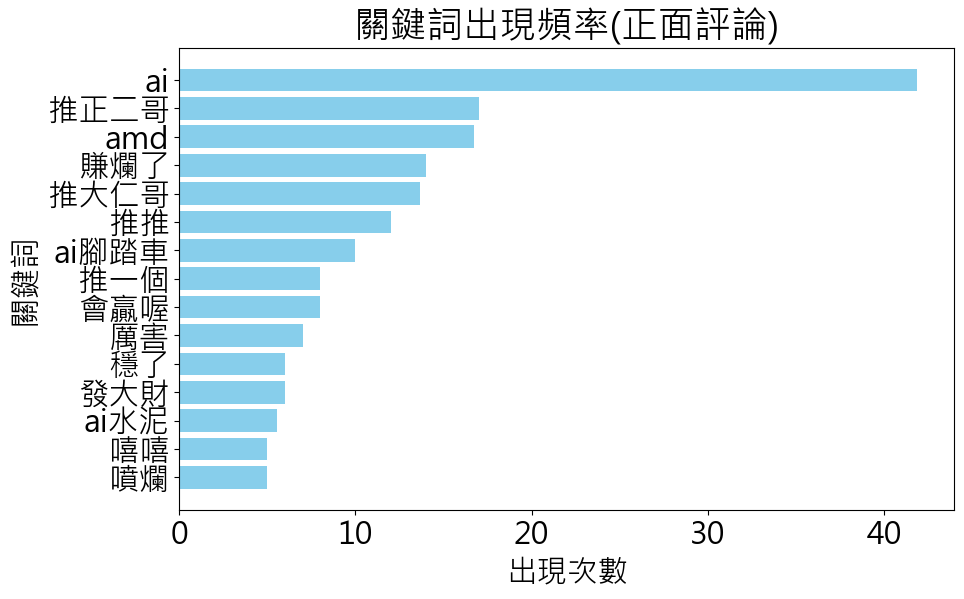

In [11]:
vectorizer = TfidfVectorizer(max_features=50)
df_pos=df[df.sentiment=='positive']
X = vectorizer.fit_transform(df_pos.push_content)

# 獲取關鍵詞列表
keywords = vectorizer.get_feature_names_out()

# 計算每個關鍵詞的總出現次數
word_count = np.sum(X.toarray(), axis=0)

# 創建關鍵詞和出現次數的數據框
keyword_df = pd.DataFrame({'keyword': keywords, 'count': word_count})

# 根據出現次數進行排序
keyword_df = keyword_df.sort_values(by='count', ascending=False)
# 繪製關鍵詞頻率圖
plt.figure(figsize=(10, 6))
plt.barh(keyword_df['keyword'][0:15], keyword_df['count'][0:15], color='skyblue')
plt.rcParams['font.sans-serif']=['Microsoft JhengHei']
plt.rcParams.update({'font.size': 22})
plt.xlabel('出現次數')
plt.ylabel('關鍵詞')
plt.title('關鍵詞出現頻率(正面評論)')
plt.gca().invert_yaxis()
plt.show()

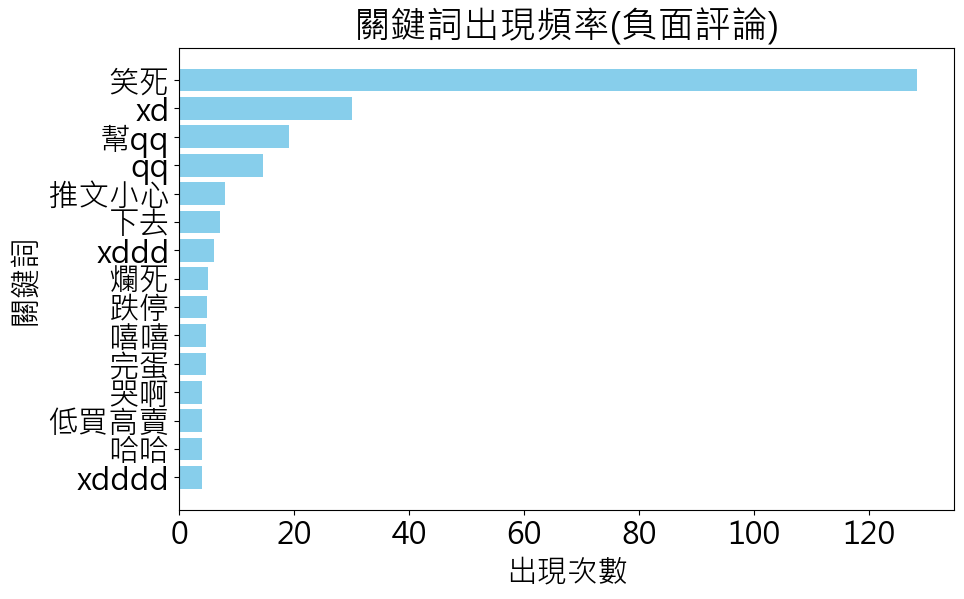

In [12]:
vectorizer = TfidfVectorizer(max_features=50)
df_neg=df[df.sentiment=='negative']
X = vectorizer.fit_transform(df_neg.push_content)

# 獲取關鍵詞列表
keywords = vectorizer.get_feature_names_out()

# 計算每個關鍵詞的總出現次數
word_count = np.sum(X.toarray(), axis=0)

# 創建關鍵詞和出現次數的數據框
keyword_df = pd.DataFrame({'keyword': keywords, 'count': word_count})

# 根據出現次數進行排序
keyword_df = keyword_df.sort_values(by='count', ascending=False)
# 繪製關鍵詞頻率圖
plt.figure(figsize=(10, 6))
plt.barh(keyword_df['keyword'][0:15], keyword_df['count'][0:15], color='skyblue')
plt.rcParams['font.sans-serif']=['Microsoft JhengHei']
plt.rcParams.update({'font.size': 22})
plt.xlabel('出現次數')
plt.ylabel('關鍵詞')
plt.title('關鍵詞出現頻率(負面評論)')
plt.gca().invert_yaxis()
plt.show()

In [13]:
df.head()

,Unnamed: 0,title,title_id,time,content,push_id,push_content,push_time,sentiment,content_cut
0,0,[新聞] 魏哲家霸氣喊「台積電無敵手」 擴廠連,keel90135 (尼可),Tue Jun 4 15:55:30 2024,原文標題：魏哲家霸氣喊「台積電無敵手」 擴廠連說3次台灣原文連結：https://finan...,xiaoyao,已知利多 我阿嬤都知道,06/04 15:57,positive,已知 利多 阿嬤都
2,2,[新聞] 魏哲家霸氣喊「台積電無敵手」 擴廠連,keel90135 (尼可),Tue Jun 4 15:55:30 2024,原文標題：魏哲家霸氣喊「台積電無敵手」 擴廠連說3次台灣原文連結：https://finan...,chinaeatshit,不說台灣明天就跌停了 說台灣又是預料中 簡單的說,06/04 15:58,negative,不說 台灣 跌停 說 台灣 預料 中 簡單 說
3,3,[新聞] 魏哲家霸氣喊「台積電無敵手」 擴廠連,keel90135 (尼可),Tue Jun 4 15:55:30 2024,原文標題：魏哲家霸氣喊「台積電無敵手」 擴廠連說3次台灣原文連結：https://finan...,chinaeatshit,就是沒有利多,06/04 15:58,negative,有利
5,5,[新聞] 魏哲家霸氣喊「台積電無敵手」 擴廠連,keel90135 (尼可),Tue Jun 4 15:55:30 2024,原文標題：魏哲家霸氣喊「台積電無敵手」 擴廠連說3次台灣原文連結：https://finan...,ship1228,無敵的時候，就會被制裁,06/04 15:58,negative,無敵 制裁
7,7,[新聞] 魏哲家霸氣喊「台積電無敵手」 擴廠連,keel90135 (尼可),Tue Jun 4 15:55:30 2024,原文標題：魏哲家霸氣喊「台積電無敵手」 擴廠連說3次台灣原文連結：https://finan...,imlucky,是吃了無敵星星嗎？哈哈,06/04 15:59,positive,吃 無敵 星星


In [14]:
# 文本向量化
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df['content_cut'])
sequences = tokenizer.texts_to_sequences(df['content_cut'])
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
max_sequence_length = 50
data = pad_sequences(sequences, maxlen=max_sequence_length)

Found 6871 unique tokens.


In [15]:
# 將標籤轉換為數字格式
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(df['sentiment'])
labels = to_categorical(np.asarray(labels))
# 分割數據集為訓練集和測試集
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42,shuffle=True)

In [16]:
len(np.unique(labels))

2

In [17]:
# 構建改進的LSTM模型
model = Sequential()
model.add(Embedding(input_dim=len(word_index) + 1, output_dim=100, input_length=max_sequence_length))
model.add(SpatialDropout1D(0.2))
model.add(Bidirectional(GRU(128, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(np.unique(labels)), activation='softmax'))
print(model.summary())
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 100)           687200    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 50, 100)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               176640    
_________________________________________________________________
dense (Dense)                (None, 64)                16448     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
Total params: 880,418
Trainable params: 880,418
Non-trainable params: 0
__________________________________________________

In [18]:
# 使用EarlyStopping回調來防止過擬合
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
# 訓練模型
epochs = 15  # 增加訓練次數
batch_size = 256

history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, y_test), verbose=2, callbacks=[early_stopping])

Epoch 1/15
13/13 - 23s - loss: 0.6824 - accuracy: 0.5590 - val_loss: 0.6606 - val_accuracy: 0.6412
Epoch 2/15
13/13 - 13s - loss: 0.5914 - accuracy: 0.7517 - val_loss: 0.5027 - val_accuracy: 0.7939
Epoch 3/15
13/13 - 13s - loss: 0.3279 - accuracy: 0.8842 - val_loss: 0.3165 - val_accuracy: 0.8667
Epoch 4/15
13/13 - 14s - loss: 0.1439 - accuracy: 0.9491 - val_loss: 0.3415 - val_accuracy: 0.8800
Epoch 5/15
13/13 - 13s - loss: 0.0820 - accuracy: 0.9748 - val_loss: 0.4199 - val_accuracy: 0.8594
Epoch 6/15
13/13 - 12s - loss: 0.0508 - accuracy: 0.9821 - val_loss: 0.4568 - val_accuracy: 0.8739


In [19]:
model.save('GRU7.h5')

In [20]:
def show_train_history(train_history,train,validation,title):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('train history')
    plt.ylabel(title)
    plt.xlabel('epoch')
    plt.legend(['train','validation'])
    plt.show()

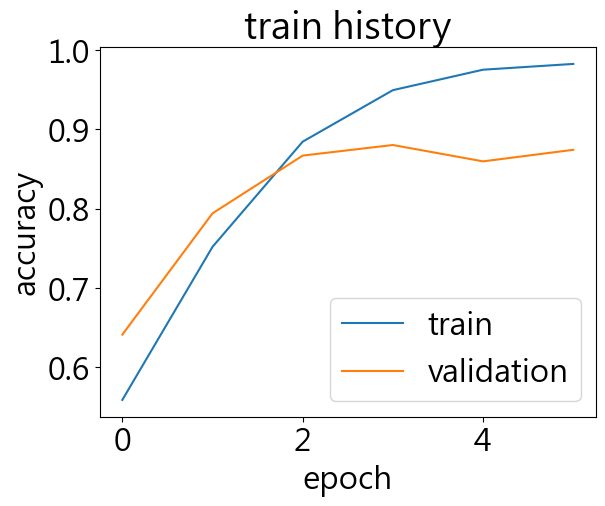

In [21]:
show_train_history(history,'accuracy','val_accuracy','accuracy')

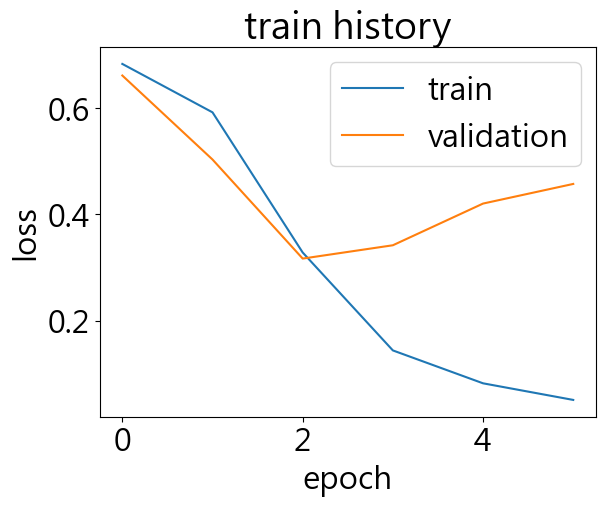

In [22]:
show_train_history(history,'loss','val_loss','loss')

In [23]:
model.evaluate(x_test,y_test)

26/26 [==============================] - 3s 96ms/step - loss: 0.3165 - accuracy: 0.8667


[0.31649133563041687, 0.8666666746139526]

In [24]:
test_texts = [
    "這家公司最近業績提升，股價上漲",
    "經濟衰退導致市場低迷，投資者損失慘重",
    "市場份額增加，銷售創新高",
    "公司破產重組，裁員大幅增加",
    "新的投資計劃將帶來更多收益",
    "市場需求減少，營收下降",
    "創新技術提高了生產效率",
    "由於貿易戰，企業面臨巨大風險",
    "公司宣布派發高額股息",
    "供應鏈問題導致生產停滯",
    "企業獲得政府補貼，財務狀況改善",
    "高失業率影響消費者信心",
    "新產品發布，市場反應熱烈",
    "全球經濟放緩，市場前景不明",
    "公司擴展到新市場，預期收益增長",
    "高通貨膨脹壓力持續存在",
    "企業進行大規模重組，預計減少成本",
    "公司成功收購競爭對手，市場份額上升",
    "債務問題加劇，企業面臨破產風險",
    "營業額增長超出預期，股價飆升"
]
test =pd.DataFrame(test_texts,columns=['test_texts'])
test['assign_sentiment']=test.test_texts.apply(classify_sentence)
test=test.dropna()
test

,test_texts,assign_sentiment
0,這家公司最近業績提升，股價上漲,positive
1,經濟衰退導致市場低迷，投資者損失慘重,negative
2,市場份額增加，銷售創新高,positive
3,公司破產重組，裁員大幅增加,negative
4,新的投資計劃將帶來更多收益,positive
5,市場需求減少，營收下降,negative
6,創新技術提高了生產效率,positive
7,由於貿易戰，企業面臨巨大風險,negative
9,供應鏈問題導致生產停滯,negative
10,企業獲得政府補貼，財務狀況改善,positive


In [25]:
test.test_texts =test.test_texts.apply(remove_stopwords)
pred_label2= label_encoder.fit_transform(test['assign_sentiment'])
pred_label2 = to_categorical(np.asarray(pred_label2))
tokenizer.fit_on_texts(test.test_texts)
sequences2 = tokenizer.texts_to_sequences(test.test_texts)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
max_sequence_length = 50
data2 = pad_sequences(sequences2, maxlen=max_sequence_length)

Found 6899 unique tokens.


In [26]:
pred=model.predict(data2)
y_pred_class = np.argmax(np.array(pred), axis=1)
y_pred_label = np.argmax(np.array(pred_label2), axis=1)
from sklearn.metrics import classification_report
print(classification_report(y_pred_label,y_pred_class))

              precision    recall  f1-score   support

           0       0.82      0.90      0.86        10
           1       0.86      0.75      0.80         8

    accuracy                           0.83        18
   macro avg       0.84      0.82      0.83        18
weighted avg       0.84      0.83      0.83        18



In [27]:
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import TextClassificationPipeline
from opencc import OpenCC
# Use the appropriate model name from the Hugging Face Model Hub
model_name = "yiyanghkust/finbert-tone-chinese"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = TFBertForSequenceClassification.from_pretrained(model_name)
tokenizer = BertTokenizer.from_pretrained(model_name)
PipelineInterface = TextClassificationPipeline(model=model, tokenizer=tokenizer,top_k=1)
test_texts = [
    "這家公司最近業績提升，股價上漲",
    "經濟衰退導致市場低迷，投資者損失慘重",
    "市場份額增加，銷售創新高",
    "公司破產重組，裁員大幅增加",
    "新的投資計劃將帶來更多收益",
    "市場需求減少，營收下降",
    "創新技術提高了生產效率",
    "由於貿易戰，企業面臨巨大風險",
    "公司宣布派發高額股息",
    "供應鏈問題導致生產停滯",
    "企業獲得政府補貼，財務狀況改善",
    "高失業率影響消費者信心",
    "新產品發布，市場反應熱烈",
    "全球經濟放緩，市場前景不明",
    "公司擴展到新市場，預期收益增長",
    "高通貨膨脹壓力持續存在",
    "企業進行大規模重組，預計減少成本",
    "公司成功收購競爭對手，市場份額上升",
    "債務問題加劇，企業面臨破產風險",
    "營業額增長超出預期，股價飆升"
]
cc = OpenCC('t2s')
for i in test_texts:
    text=cc.convert(i)
    print(text)
    label=PipelineInterface(text)
    print(label)

C:\Users\user\anaconda3\envs\tf_2.6_py_3.9\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
All PyTorch model weights were used when initializing TFBertForSequenceClassification.

All the weights of TFBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


这家公司最近业绩提升，股价上涨
[[{'label': 'Positive', 'score': 0.9990265369415283}]]
经济衰退导致市场低迷，投资者损失惨重
[[{'label': 'Negative', 'score': 0.9987496137619019}]]
市场份额增加，销售创新高
[[{'label': 'Positive', 'score': 0.9991223216056824}]]
公司破产重组，裁员大幅增加
[[{'label': 'Negative', 'score': 0.9942041039466858}]]
新的投资计划将带来更多收益
[[{'label': 'Positive', 'score': 0.9870779514312744}]]
市场需求减少，营收下降
[[{'label': 'Negative', 'score': 0.9978594183921814}]]
创新技术提高了生产效率
[[{'label': 'Positive', 'score': 0.9989935755729675}]]
由于贸易战，企业面临巨大风险
[[{'label': 'Negative', 'score': 0.9983343482017517}]]
公司宣布派发高额股息
[[{'label': 'Neutral', 'score': 0.9919643402099609}]]
供应链问题导致生产停滞
[[{'label': 'Negative', 'score': 0.9981504082679749}]]
企业获得政府补贴，财务状况改善
[[{'label': 'Positive', 'score': 0.9990265369415283}]]
高失业率影响消费者信心
[[{'label': 'Negative', 'score': 0.988723874092102}]]
新产品发布，市场反应热烈
[[{'label': 'Positive', 'score': 0.9971762895584106}]]
全球经济放缓，市场前景不明
[[{'label': 'Negative', 'score': 0.9967221617698669}]]
公司扩展到新市场，预期收益增长
[[{'label': 'Positive',